In [4]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import os
import soundfile as sf
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer, T5Tokenizer, T5EncoderModel, AutoTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
%matplotlib inline

In [ ]:
temp_vae_path = "/blob/v-yuancwang/AudioEditing/Finetune_VAE_2/checkpoint-110000"
vae = AutoencoderKL.from_pretrained(temp_vae_path, subfolder="vae")
vae.requires_grad_(False)

In [ ]:
torch_device = "cuda:0"
vae.to(torch_device)

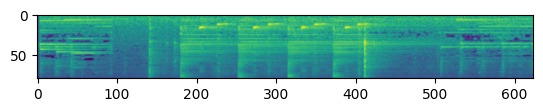

In [13]:
test_data_path = "/blob/v-yuancwang/audio_editing_data/audiocaps/mel"
test_mel = np.load(os.path.join(test_data_path, "--CHY2qO5zc.npy"))
plt.imshow(test_mel)

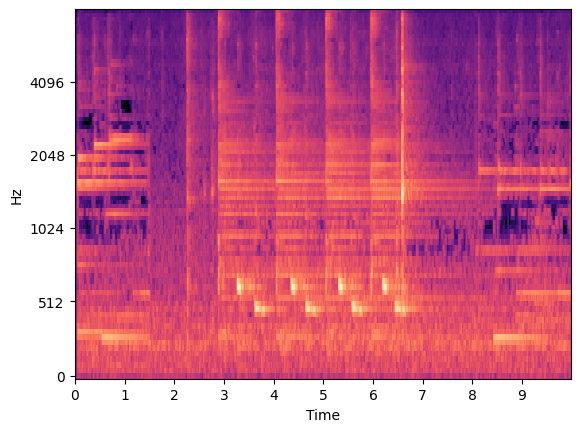

In [14]:
librosa.display.specshow(test_mel, sr=16000, hop_length=256, x_axis='time', y_axis='mel')
plt.show()

torch.Size([1, 1, 80, 624])


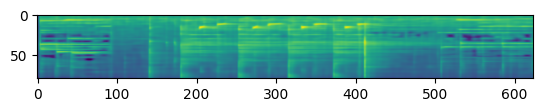

In [18]:
with torch.no_grad():
    res_mel = torch.Tensor([[test_mel]]).to(torch.float32)
    res_mel = res_mel.to(torch_device)
    print(res_mel.shape)
    res_mel = vae(res_mel, sample_posterior=True).sample
    res_mel = res_mel.cpu().numpy()[0,0,:,:]
np.save("/home/v-yuancwang/AudioEditing/hifigan_test/test0.npy", np.array([res_mel]))
plt.imshow(res_mel)

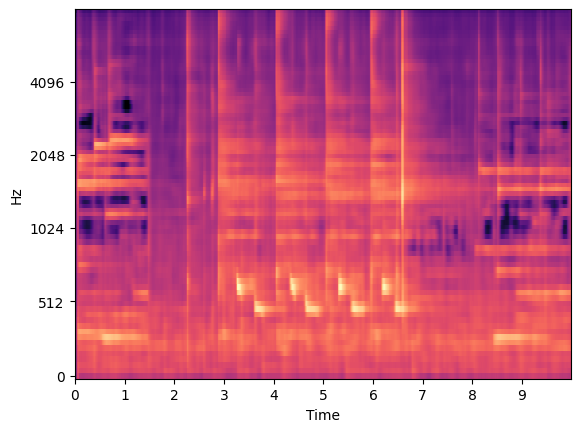

In [19]:
librosa.display.specshow(res_mel, sr=16000, hop_length=256, x_axis='time', y_axis='mel')
plt.show()

In [8]:
unet = UNet2DConditionModel.from_config("/home/v-yuancwang/AudioEditing/MyPipeline", subfolder="unet")
temp = torch.randn((1, 8, 78, 10))
t = 1
e = torch.randn((1, 10, 768))
print(unet(temp, t, e).sample.shape)

torch.Size([1, 4, 78, 10])


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")
captions = ['hello world!','my name is Tom.']
inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding="do_not_pad", truncation=True)
input_ids = inputs.input_ids
print(input_ids)
padded_tokens = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt")
print(padded_tokens.input_ids)
print(padded_tokens.attention_mask)

In [ ]:
text_encoder = T5EncoderModel.from_pretrained("t5-base")
text_encoder.requires_grad_(False)
encoder_hidden_states = text_encoder(padded_tokens.input_ids, padded_tokens.attention_mask)[0]
print(encoder_hidden_states.shape)